# Performance analysis of TinyABE, RW13 and Att19

In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt

Setting up variables and functions for converting cycles to ms. 

In [2]:
cyclesperms = 1600000
def convert_cycles_to_ms(x):
    return x/cyclesperms

def ms_round(x):
    return float(round(Decimal(convert_cycles_to_ms(x)),1))

def sec_round(x):
    return float(round(Decimal(x),1))

def bitstokb(x):
    return float(round(Decimal(x/(8*1024)),2))

Setting up the sizes of the elements in the BLS12-381 curve groups (in bits).

In [3]:
G1size = np.ceil(381/8)*8
G2size = 2*G1size+8
Gtsize = 12*G1size
Zpsize = np.ceil(255/8)*8

Initiating operational costs of the group operations.

In [4]:
## Group G
g1_add = 0
g1_mul = 0
g1_mul_fix = 0
g1_mul_sim = 0
g1_map = 0

## Group H
g2_add = 0
g2_mul = 0
g2_mul_fix = 0
g2_mul_sim = 0
g2_map = 0

## Group Gt
gt_exp = 0 

## Pairings
pair = 0
pair_one_more = 0

Functions to assign values to operational costs.

In [5]:
def convlistcycles(lis):
    cpy = []
    for x in lis:
        cpy.append(convert_cycles_to_ms(x))
    return cpy

def setg1(add, mul, mulfix, mulsim, mmap):
    global g1_add, g1_mul, g1_mul_fix, g1_mul_sim, g1_map
    
    lis = [add, mul, mulfix, mulsim, mmap]
    
    g1_add = add
    g1_mul = mul
    g1_mul_fix = mulfix 
    g1_mul_sim = mulsim  
    g1_map = mmap
    
def setg2(add, mul, mulfix, mulsim, mmap):
    global g2_add, g2_mul, g2_mul_fix, g2_mul_sim, g2_map
    
    lis = [add, mul, mulfix, mulsim, mmap]
    
    g2_add = add
    g2_mul = mul
    g2_mul_fix = mulfix 
    g2_mul_sim = mulsim  
    g2_map = mmap
    
def setgtandpair(exp, p, pairom):
    global gt_exp, pair, pair_one_more
    
    lis = [exp, p, pairom]
    
    gt_exp = exp

    pair = p
    pair_one_more = pairom

Settings for a 1.6 GHz Intel i5-8250U processor based on RELIC benchmarks.

In [6]:
def settingscomp():
    setg1(4012, 344153, 183034, 444967, 100814)  
    setg2(7291, 696302, 416068, 1297889, 601587)
    setgtandpair(1162560, 2159046, 633144)
    global opts
    opts = True

Settings for the Arduino Nano 33 BLE Cortex-M4 (in seconds)

In [7]:
def settingsarduino():
    # additions and hashes are approximations based on Intel benchmarks
    # no optimizations used for mul_fix and mul_sim
    g1_mul = 0.141
    g2_mul = 0.31
    setg1(g1_mul/85, g1_mul, g1_mul, 2*g1_mul, g1_mul/3)
    setg2(g2_mul/95, g2_mul, g2_mul, 2*g2_mul, 0)
    setgtandpair(0.430, 0.514 + 0.713 , 0.514)
    global opts
    opts = False

Settings for the Fishino Pirhanha MIPS32 (in seconds)

In [8]:
def settingsfishino():
    # additions and hashes are approximations, no optimizations used for mul_fix and mul_sim
    g1_mul = 0.075
    g2_mul = 0.167
    setg1(g1_mul/85, g1_mul, g1_mul, 2*g1_mul, g1_mul/3)
    setg2(g2_mul/95, g2_mul, g2_mul, 2*g2_mul, 0)
    setgtandpair(0.223, 0.386 + 0.273, 0.273)
    global opts
    opts = False

Function for multi-exponentiations, which may be faster than simply computing the product of multiple exponentiations. If using fixed-base exponentiations are faster, it uses those.
This function also checks if optimalizations may be used or not (which is the case on the Intel processor but not on the IoT devices.) 

In [9]:
def multiexp(x):
    if opts:
        fix = x*g1_mul_fix
        if x > 1:
            g1_mul_onemore = g1_mul_sim - g1_mul
            sim = g1_mul_sim+(x-2)*g1_mul_onemore
        else:
            sim = g1_mul_fix
        if fix < sim:
            return fix
        else: 
            return sim
    else:
        return x*g1_mul

**TinyABE**

*Storage costs*

In [10]:
def MPKsizesTinyABE(n_k,hatn1,hatn2,atts):
    gh = G1size + G2size
    Bij = (n_k+1)*hatn1*G1size
    Bjk = hatn1*hatn2*G1size
    return 2*(gh + Bij + Bjk) + Gtsize

def keysizesTinyABE(n_k,hatn1,hatn2,atts):
    m = np.ceil(atts/n_k)
    k1 = hatn1*m*G2size
    k2 = hatn1*hatn2*m
    k3 = hatn1*(hatn1-1)*hatn2*m
    k4 = hatn1*atts
    k5 = n_k*hatn1*(hatn1-1)*m
    ktot = (k2 + k3 + k4 + k5)*G2size
    return 2*(k1 + ktot)

def ciphertextsizesTinyABE(n_k,hatn1,hatn2,atts):
    m = np.ceil(atts/hatn1)
    c = Gtsize
    cp = G1size
    c1 = m*G1size
    return c + 2*(cp + c1)

*Computational costs*

In [11]:
def keycostTinyABE(n_k,hatn1,hatn2,atts):
    m = np.ceil(atts/n_k)
    k1 = hatn1*m*g2_mul_fix
    k2 = hatn1*hatn2*m
    k3 = hatn1*(hatn1-1)*hatn2*m
    k4 = hatn1*atts
    k5 = n_k*hatn1*(hatn1-1)*m
    ktot = (k2 + k3 + k4 + k5)*g2_mul_fix
    return 2*(k1 + ktot)

# This function determines the most efficient way to compute C'
def mincostcp(n_k,hatn1,hatn2,atts):
    m1p = np.ceil(atts/hatn1)
    m2p = np.ceil(atts/hatn2)
    fixedcosts = multiexp(n_k*np.min([hatn1,atts]))
    maxcostscap =  multiexp(hatn1*hatn2)
    other1cap = multiexp(m2p) + atts**2*g1_add
    if other1cap < maxcostscap:
        capcosts = other1cap
    else: capcosts = maxcostscap
    maxcostscatt = multiexp(hatn1)
    other1catt = multiexp(m1p) + atts*g1_add
    if other1catt < maxcostscatt:
        cattcosts = other1catt 
    else: cattcosts = maxcostscatt
    return fixedcosts + capcosts + cattcosts

def enccostTinyABE(n_k,hatn1,hatn2,atts):
    m1p = np.ceil(atts/hatn1)
    if np.ceil(atts/hatn2) > m1p:
        m1p = np.ceil(atts/hatn2)
    c1 = m1p*g1_mul_fix
    cp = mincostcp(n_k,hatn1,hatn2,atts)
    return gt_exp + 2*(cp + c1)

def deccostTinyABE(n_k,hatn1,hatn2,atts):
    m1p = np.ceil(atts/hatn1)
    paircosts = pair + m1p * pair_one_more
    c1 = atts*g2_add
    c23 = hatn1*atts**2*g2_add
    c45 = n_k*atts*g2_mul + n_k*atts**2*g2_add
    return 2*(paircosts + c1 + c23 + c45)

**RW13**

*Storage costs*

In [12]:
def MPKsizeRW13(atts):
    return Gtsize + 2*(5*G1size + G2size)

def keysizeRW13(atts):
    return 2*(2+2*atts)*G2size

def ciphertextsizeRW13(atts):
    c = Gtsize
    crest = 3*atts*G1size   
    return c + 2*crest

*Computational costs*

In [13]:
def keycostRW13(atts):
    k = g2_mul_fix
    kp = g2_mul_fix
    k1att = atts*g2_mul_fix
    k2l = atts*g2_mul_fix
    return 2*(k + kp + k1att + k2l)

def enccostRW13(atts):
    cp = g1_mul_fix
    c1 = atts*multiexp(2)
    c2 = atts*multiexp(2)
    c3 = atts*g1_mul_fix
    return gt_exp + 2*(cp + c1 + c2 + c3)

def deccostRW13(atts):
    nrpairings = 2*atts
    paircosts = ((pair + nrpairings * pair_one_more) + pair_one_more)
    return 2*paircosts

Choosing settings for TinyABE

In [14]:
TinyABEsettings = [(1,3), (1,13)]

Returns appropriate function.

In [15]:
def determinefunc(scheme, cost, opt, extr):
    if scheme == 'TinyABE' or scheme == 'Att19':
        if len(extr) < 3:
            print("Error, not enough arguments for extr")
            print(scheme, cost, opt, extr)
            n_k = 0
            hatn1 = 0
            hatn2 = 0
        else: 
            n_k = extr[0]
            hatn1 = extr[1]
            hatn2 = extr[2]
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: MPKsizesTinyABE(n_k,hatn1,hatn2,atts)
            if opt == 'SK':
                return lambda atts: keysizesTinyABE(n_k,hatn1,hatn2,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizesTinyABE(n_k,hatn1,hatn2,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: keycostTinyABE(n_k,hatn1,hatn2,atts)
            if opt == 'Enc':
                return lambda atts: enccostTinyABE(n_k,hatn1,hatn2,atts)
            if opt == 'Dec':
                return lambda atts: deccostTinyABE(n_k,hatn1,hatn2,atts)
    if scheme == 'RW13':
        if cost == 'S':
            if opt == 'MPK':
                return MPKsizeRW13
            if opt == 'SK':
                return keysizeRW13
            if opt == 'CT':
                return ciphertextsizeRW13
        if cost == 'C': 
            if opt == 'KG':
                return keycostRW13
            if opt == 'Enc':
                return enccostRW13
            if opt == 'Dec':
                return deccostRW13
    if scheme == 'BSW07':
        if cost == 'C' and opt == 'Enc':
            return enccostBSW07
        if cost == 'S' and opt == 'CT':
            return ciphertextsizeBSW07
    if scheme == 'FAME':
        if cost == 'C' and opt == 'Enc':
            return enccostFAME
        if cost == 'S' and opt == 'CT':
            return ciphertextsizeFAME
    if scheme == 'ABGW17':
        if cost == 'C' and opt == 'Enc':
            return enccostABGW17
        if cost == 'S' and opt == 'CT':
            return ciphertextsizeABGW17
    return lambda x: x
            
def determinelabels(cost, opt):
    if cost == 'S':
        ylab = 'Size in KB'
        if opt == 'SK':
            title = 'Key sizes'
            xlab = 'Size of the set of attributes'
        if opt == 'CT':
            title = 'Ciphertext sizes'
            xlab = 'Length of the policy'
    if cost == 'C':
        if opts:
            ylab = 'Time in ms'
        else:
            ylab = 'Time in seconds'
        if opt == 'KG':
            title = 'Key generation costs'
            xlab = 'Size of the set of attributes'
        if opt == 'Enc':
            title = 'Encryption costs'
            xlab = 'Length of the policy'
        if opt == 'Dec':
            title = 'Decryption costs'
            xlab = 'Number of matching attributes'
    return (xlab,ylab,title)

Settings and functions to plot everything.

In [16]:
maxsize = 101
listoplot = [('RW13', [0]), ('Att19', [1,100,100])]

In [17]:
def plotcosts(cost, opt, lis):
    sizes = list(range(1,maxsize))
    nrmarks = len(lis) + len(TinyABEsettings)
    markers = ["$" + str(i+1) + "$" for i in range(nrmarks)]
    plt.style.use("ggplot")
    
    if cost == 'C':
        if opts:
            rnd = ms_round
        else:
            rnd = sec_round
    else: 
        rnd = bitstokb
    
    c = 0
    for (x,y) in TinyABEsettings:
        tiny = []
        for z in sizes: 
            tiny.append(rnd(determinefunc('TinyABE', cost, opt, [x,y,y])(z)))
        plt.plot(sizes, tiny, label='TinyABE$_{(' + str(x) + ',' + str(y) + ',' + str(y) + ')}$', 
                 marker=markers[c], markevery=(c*5,nrmarks*5))
        c += 1
    
    for (scheme, extr) in lis:
        sch = []
        for z in sizes:
            sch.append(rnd(determinefunc(scheme, cost, opt, extr)(z)))
        plt.plot(sizes, sch, label=scheme, marker=markers[c], markevery=(c*5,nrmarks*5))
        c += 1
    
    (xlab,ylab,title) = determinelabels(cost, opt)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.show()
    plt.close()

In [18]:
def SKcosts():
    plotcosts('S', 'SK', listoplot)
    
def CTcosts():
    plotcosts('S', 'CT', listoplot)

def keygencosts():
    plotcosts('C', 'KG', listoplot)

def encryptioncosts():
    plotcosts('C', 'Enc', listoplot)
    
def decryptioncosts():
    plotcosts('C', 'Dec', listoplot)
    
def plotall():
    SKcosts()
    CTcosts()
    keygencosts()
    encryptioncosts()
    decryptioncosts()

**Plots for Intel processor**

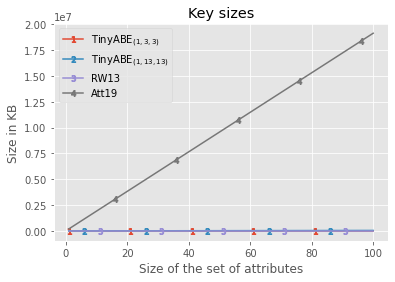

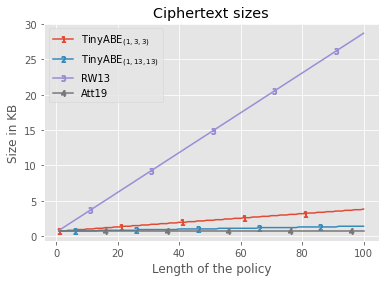

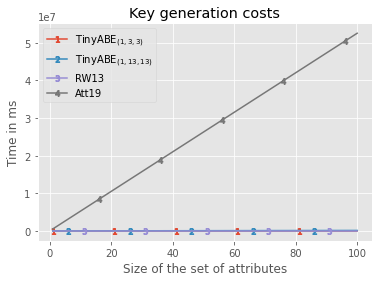

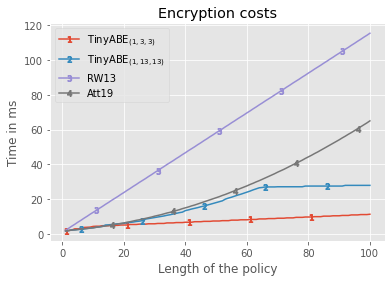

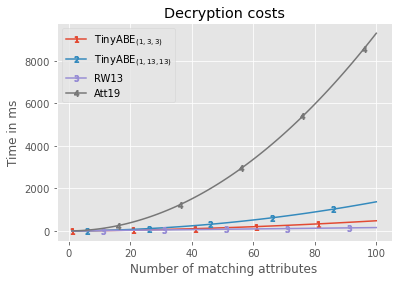

In [19]:
settingscomp()
plotall()

**Plots for Arduino**

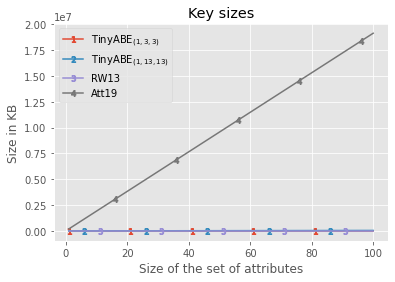

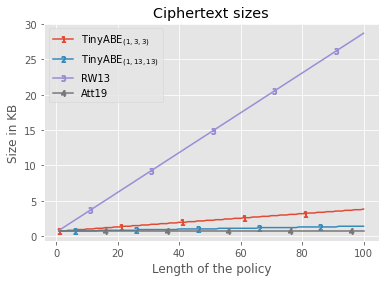

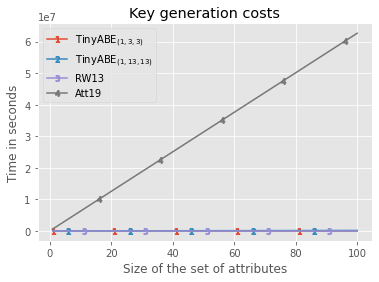

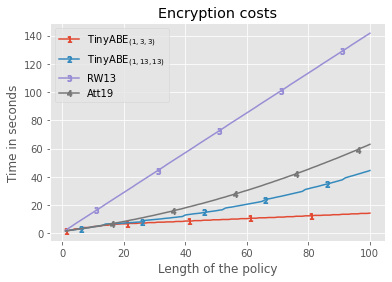

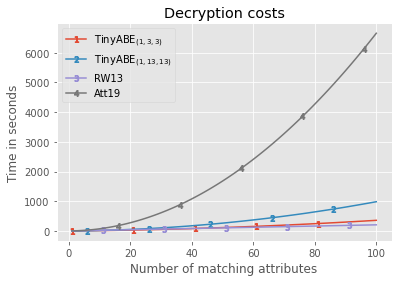

In [20]:
settingsarduino()
plotall()

**Plots for Fishino**

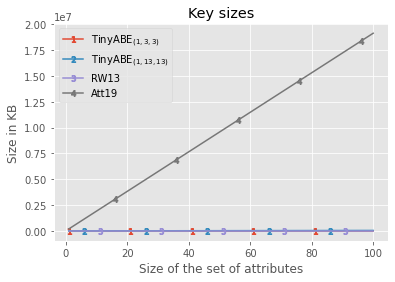

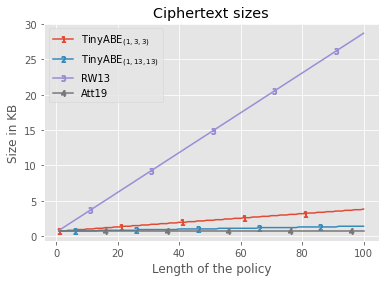

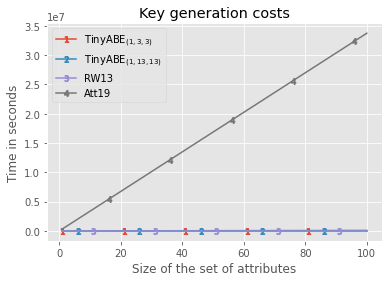

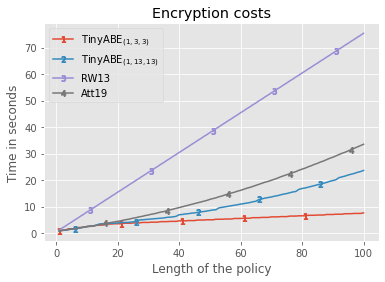

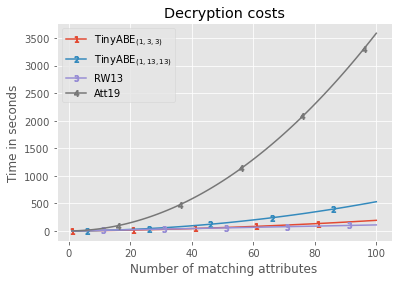

In [21]:
settingsfishino()
plotall()

**Comparing encryption efficiency with other schemes on the Intel processor**

In [22]:
## ABGW17
def ciphertextsizeABGW17(atts):
    return Gtsize + 2*(atts*(2*G1size + G1size))

def enccostABGW17(atts):
    return gt_exp + 2*(atts*(2*multiexp(2) + g1_mul_fix))

## FAME
def ciphertextsizeFAME(atts):
    c0 = 3*G2size
    ci = 3*atts*G1size
    cp = Gtsize
    return c0 + ci + cp

def enccostFAME(atts):
    c0 = 3*g2_mul_fix
    # We assume that only two entries in one row of the access matrix are non-zero
    ci = 3*atts*(multiexp(2) + 4*g1_map)
    cp = 2*gt_exp
    return c0 + ci + cp

## BSW07
def ciphertextsizeBSW07(atts):
    cp = Gtsize
    c1i = atts*G1size
    c2i = atts*G2size
    c3 = G1size
    return cp + 2*(c1i + c2i + c3)

def enccostBSW07(atts):
    cp = gt_exp
    c1i = atts*(g1_mul + g1_map)
    c2i = atts*(g2_mul_fix)
    c3 = g1_mul_fix
    return cp + 2*(c1i + c2i + c3)

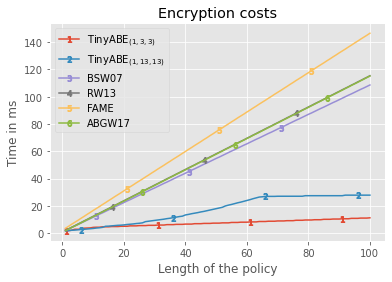

In [23]:
listoplot = [('BSW07', [0]), ('RW13', [0]), ('FAME', [0]), ('ABGW17', [0])]
settingscomp()
encryptioncosts()

## Packet loss

We also analyze the impact that the size of the ciphertexts have on the packet loss rates.

In [24]:
# This function computes the probability that one of the packets containing the ciphertext drops.
def probether(x,p):
    nrpackets = np.ceil(x/(1500*8))
    return (1 - (1-p)**nrpackets)*100

In [25]:
def plotpacketloss(nrattributes, lis):
    maxprobs = 20
    probs = [i/100 for i in range(1,maxprobs+1)] 
    probspercen = [i for i in range(1,maxprobs+1)]
    nrmarks = len(lis) + len(TinyABEsettings)
    markers = ["$" + str(i+1) + "$" for i in range(nrmarks)]
    plt.style.use("ggplot")
    
    c = 0
    for (x,y) in TinyABEsettings:
        tiny = []
        for z in probs: 
            tinyCT = determinefunc('TinyABE', 'S', 'CT', [x,y,y])(nrattributes)
            tiny.append(probether(tinyCT,z))
        plt.plot(probspercen, tiny, label='TinyABE$_{(' + str(x) + ',' + str(y) + ',' + str(y) + ')}$', 
                 marker=markers[c], markevery=(c,nrmarks))
        c += 1
    
    for (scheme, extr) in lis:
        sch = []
        for z in probs:
            schCT = determinefunc(scheme, 'S', 'CT', extr)(nrattributes)
            sch.append(probether(schCT,z))
        plt.plot(probspercen, sch, label=scheme, marker=markers[c], markevery=(c,nrmarks))
        c += 1
    
    plt.xlabel('Packet loss rate in %')
    plt.ylabel('Probability')
    plt.title('Probability of retransmission (' + str(nrattributes) + ' attributes)')
    plt.legend()
    plt.show()
    plt.close()

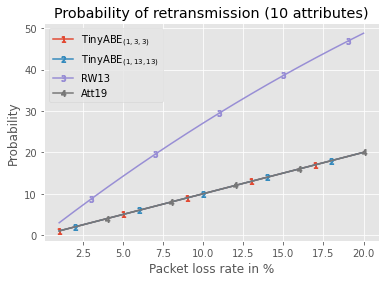

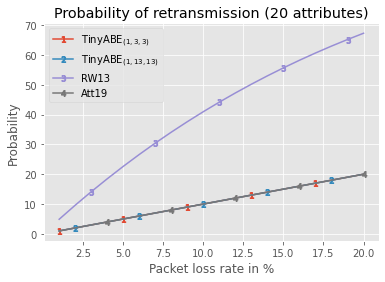

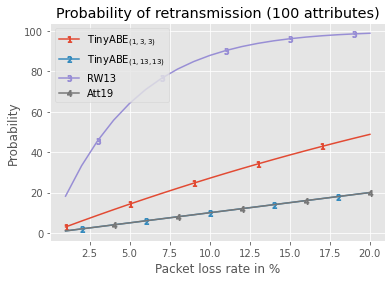

In [26]:
listoplot = [('RW13', [0]), ('Att19', [1,100,100])]
# uncomment the line below for a larger list to plot
# listoplot = [('BSW07', [0]), ('RW13', [0]), ('FAME', [0]), ('ABGW17', [0]), ('Att19', [1,100,100])]
plotpacketloss(10, listoplot)
plotpacketloss(20, listoplot)
plotpacketloss(100, listoplot)